### Notebook 2  

# Google Analytics Customer Revenue Prediction

## Problem Statement
The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies. For this project,we are challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset and identify the best model to predict the probability of the session being revenue-generating.


## File Descriptions
 - train.csv - the Google Analytics Dataset


## Data Fields
 -  fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
 - channelGrouping - The channel via which the user came to the Store.
 - date - The date on which the user visited the Store.
 - device - The specifications for the device used to access the Store.
 - geoNetwork - This section contains information about the geography of the user.
 - sessionId - A unique identifier for this visit to the store.
 - socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
 - totals - This section contains aggregate values across the session.
 - trafficSource - This section contains information about the Traffic Source from which the session originated.
 - visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, we should use a combination of fullVisitorId and visitId.
 - visitNumber - The session number for this user. If this is the first session, then this is set to 1.
 - visitStartTime - The timestamp (expressed as POSIX time).
 - hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
 - customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
 - totals - This set of columns mostly includes high-level aggregate data.
 
 
 ### Contents
- [Initialization](#Initialization)
- [Read in Train Data](#Train-Data)
- [Identify categorical and numerical columns](#Identify-categorical-and-numerical-columns)
- [Missing Values Imputation](#Missing-Values-Imputation)
- [Feature Engineering](#Feature-Engineering)
- [Preprocessing](#Preprocessing)
- [Modelling](#Modelling)

## Initialization

In [1]:
#Import Vanilla Libraries
import numpy as np
import pandas as pd

#Plot 
import matplotlib.pyplot as plt
import seaborn as sns

# Random Sampling Libraries
from imblearn.under_sampling import RandomUnderSampler

#Machine Learning Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, recall_score,f1_score,auc,roc_curve,roc_auc_score,classification_report, accuracy_score
from scipy.stats import chi2_contingency, chi2, boxcox, iqr, zscore

pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 100)

## Train Data

In [2]:
#Read in training dataset
train = pd.read_csv('./data/train_flatten.csv', low_memory=False)

In [3]:
#Check the train information after reading in
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 41 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   channelGrouping                               903653 non-null  object 
 1   date                                          903653 non-null  object 
 2   fullVisitorId                                 903653 non-null  object 
 3   sessionId                                     903653 non-null  object 
 4   visitId                                       903653 non-null  int64  
 5   visitNumber                                   903653 non-null  int64  
 6   visitStartTime                                903653 non-null  int64  
 7   device_browser                                903653 non-null  object 
 8   device_operatingSystem                        903653 non-null  object 
 9   device_isMobile                               90

## Identify categorical and numerical columns

### Categorical columns

In [4]:
#Remove columns which do not add value to the analysis before label encoding
train.drop(['fullVisitorId', 
             'trafficSource_keyword',
             'trafficSource_isTrueDirect',
             'trafficSource_referralPath',
             'trafficSource_adwordsClickInfo.page',
             'trafficSource_adwordsClickInfo.slot',
             'trafficSource_adwordsClickInfo.gclId',
             'trafficSource_adwordsClickInfo.adNetworkType',
             'trafficSource_adwordsClickInfo.isVideoAd',
            'trafficSource_campaignCode',
            'trafficSource_campaign',
            'geoNetwork_networkDomain',
            'date',
            'visitId',
            'visitStartTime',
            'visitNumber',
            'sessionId',
           'totals_transactionRevenue'],axis =1, inplace=True)
                                   

In [5]:
#Identify categorical columns
categorical_cols = list()
for i in train.columns:
    if (train[i].dtype=='object' or train[i].dtype=='bool') and (not(i.startswith('total'))):
        categorical_cols.append(i)

In [6]:
# manually add to categorical some of the numerical columns which are actually categorical
categorical_cols.extend(['month', 'day', 'weekday', 'visitHour','totals_bounces', 'totals_newVisits'])

In [7]:
#list of categorical columns
categorical_cols

['channelGrouping',
 'device_browser',
 'device_operatingSystem',
 'device_isMobile',
 'device_deviceCategory',
 'geoNetwork_continent',
 'geoNetwork_subContinent',
 'geoNetwork_country',
 'geoNetwork_region',
 'geoNetwork_metro',
 'geoNetwork_city',
 'trafficSource_source',
 'trafficSource_medium',
 'trafficSource_adContent',
 'month',
 'day',
 'weekday',
 'visitHour',
 'totals_bounces',
 'totals_newVisits']

#### Numerical Columns

In [8]:
#identify numerical columns
numerical_cols = list()
for i in train.columns:
    if train[i].dtype not in ['object','bool']:
        numerical_cols.append(i)

In [9]:
# manually remove some cols which were added in categorical
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]
numerical_cols

['totals_hits', 'totals_pageviews', 'revenue']

In [10]:
#Check all columns are accounted for
set(train.columns)-set(numerical_cols + categorical_cols)

set()

In [11]:
# remove revenue (target variable) from numerical_cols
numerical_cols.remove('revenue')

In [12]:
#Remaining numerical columns
numerical_cols

['totals_hits', 'totals_pageviews']

## Missing Values Imputation

#### Numerical columns

In [13]:
#Check for null values
train[numerical_cols].isnull().sum()

totals_hits           0
totals_pageviews    100
dtype: int64

In [14]:
#Fill the relevant null columns with 0
train['totals_pageviews'] = train['totals_pageviews'].fillna(0)

In [15]:
train[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   totals_hits       903653 non-null  int64  
 1   totals_pageviews  903653 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 13.8 MB


In [16]:
train['totals_pageviews'] = train['totals_pageviews'].astype(int)     

#### Categorical columns

In [17]:
#Sum of missing values in categorical columns
missing = train[categorical_cols].isnull().sum()

In [18]:
#Convert to percentages
percent = missing/len(train)*100

In [19]:
#List percentage of missing values in categorical columns
percent

channelGrouping             0.000000
device_browser              0.000000
device_operatingSystem      0.000000
device_isMobile             0.000000
device_deviceCategory       0.000000
geoNetwork_continent        0.000000
geoNetwork_subContinent     0.000000
geoNetwork_country          0.000000
geoNetwork_region           0.000000
geoNetwork_metro            0.000000
geoNetwork_city             0.000000
trafficSource_source        0.000000
trafficSource_medium        0.000000
trafficSource_adContent    98.788694
month                       0.000000
day                         0.000000
weekday                     0.000000
visitHour                   0.000000
totals_bounces             50.132407
totals_newVisits           22.198012
dtype: float64

We will retain trafficSource_adContent since from the word cloud, there were some relevant keywords used hence we will fill the Null values with the word 'missing'. 

In [20]:
#Fill null with missing 
for col in ['trafficSource_adContent']:
    train[col].fillna('missing', inplace=True)

In [21]:
#Fill null with 0 since the values are binary
for col in ['totals_bounces', 'totals_newVisits']:
    train[col].fillna('0', inplace=True)

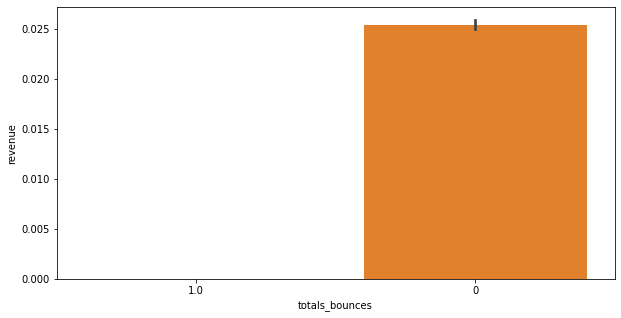

In [22]:
#Plot barpot to see the interaction with revenue
plt.figure(figsize=(10,5))
sns.barplot(x=train['totals_bounces'], y=train['revenue'], data=train)

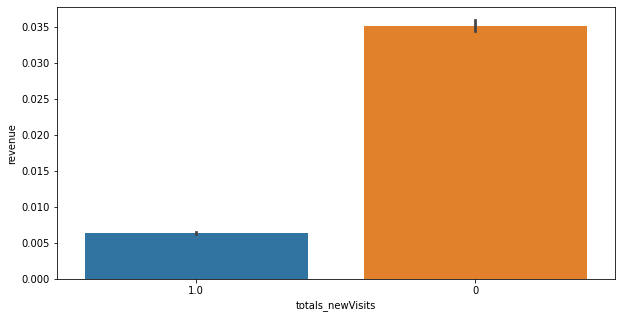

In [23]:
#Plot barpot to see the interaction with revenue
plt.figure(figsize=(10,5))
sns.barplot(x=train['totals_newVisits'], y=train['revenue'], data=train)

## Feature Engineering

### Boxplots

We will now run the boxplots on the numerical features to assess the variation against revenue

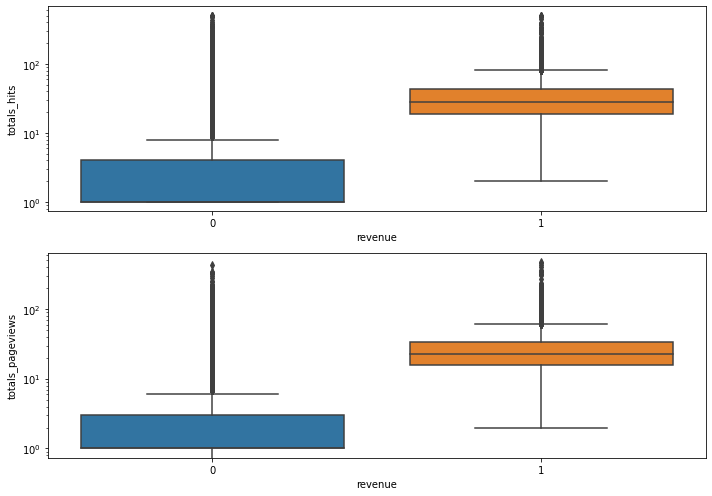

In [24]:
#Plot boxplot to see the interaction with revenue
size=15
params = {
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 10}

target = train['revenue']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize =(10,7))
ax = ax.ravel() #Ravel turns the subplot shape into vector

for i, col in enumerate(numerical_cols):
    sns.boxplot(x='revenue', y=col, data=train, orient = 'v', ax=ax[i])
    ax[i].set_xlabel('revenue')
    ax[i].set_ylabel(col)
    ax[i].set_yscale('log')
    
plt.tight_layout()   
    
    

### Label Encoding of Categorical Columns

In [25]:
#Label encoding of categorical columns

lbes = dict() # collect the label encoders to have the labels
onehots = dict() # collect one hot encoders for the labels
for col in categorical_cols:
    print("transform column {}".format(col))
    lbe = LabelEncoder()
    lbe.fit(train[col].astype("str"))
    train[col] = lbe.transform(train[col].astype("str"))
    onehots[col] = OneHotEncoder().fit(train[col].values.reshape(-1,1))
    lbes[col] = lbe

transform column channelGrouping
transform column device_browser
transform column device_operatingSystem
transform column device_isMobile
transform column device_deviceCategory
transform column geoNetwork_continent
transform column geoNetwork_subContinent
transform column geoNetwork_country
transform column geoNetwork_region
transform column geoNetwork_metro
transform column geoNetwork_city
transform column trafficSource_source
transform column trafficSource_medium
transform column trafficSource_adContent
transform column month
transform column day
transform column weekday
transform column visitHour
transform column totals_bounces
transform column totals_newVisits


Below we will perform hypothesis tests on chi square contingency tables to decide if revenue is dependent on the categorical columns to decide if any should be dropped.

In [26]:
# contingency table

for col in categorical_cols:
    groupsizes = train.groupby(['revenue', col]).size()
    ctsum = groupsizes.unstack('revenue').fillna(0)

    stat, p, dof, expected = chi2_contingency(ctsum)
    print(col)
    
    # interpret p-value
    prob = 0.95
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

channelGrouping
significance=0.050, p=0.000
Dependent (reject H0)
device_browser
significance=0.050, p=0.000
Dependent (reject H0)
device_operatingSystem
significance=0.050, p=0.000
Dependent (reject H0)
device_isMobile
significance=0.050, p=0.000
Dependent (reject H0)
device_deviceCategory
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_continent
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_subContinent
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_country
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_region
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_metro
significance=0.050, p=0.000
Dependent (reject H0)
geoNetwork_city
significance=0.050, p=0.000
Dependent (reject H0)
trafficSource_source
significance=0.050, p=0.000
Dependent (reject H0)
trafficSource_medium
significance=0.050, p=0.000
Dependent (reject H0)
trafficSource_adContent
significance=0.050, p=0.000
Dependent (reject H0)
month
significance=0.050, p

All the columns are showing as dependent. 

### Treatment of outliers

Below we will identify any outliers using 1.5 times the inter-quartile range before Q1 and after Q3 to drop the rows.

In [27]:
# before analysing IQR, transform the numerical columns to normal counterpart by boxcox transformation
# dictionary of row to be removed due to outlier (key is the columns and the values are the row index)

row2remove = dict()
for col in numerical_cols:
    # ignore binary columns
    if col not in ['totals_bounces','totals_newVisits']:
        row2remove[col] = {0:[], 1:[]}
        for rev in [0,1]:
        
            train_0 = train[train['revenue'] == rev]
            posdata = train_0.loc[(train_0[col] > 0), col]
            bc_array, bc_lambda = boxcox(posdata)
            x = np.empty_like(train_0[col].values)
            x[train_0[col] > 0] = bc_array
            x[train_0[col] <= 0] = -1/bc_lambda

            outliers_idx = abs(zscore(x))>3
            #outliers_idx = (x < np.quantile(x,0.25) - 1.5*iqr(x)) + (x > np.quantile(x,0.75) + 1.5*iqr(x))
            outliers = train_0[col].iloc[outliers_idx]
            print(f'{col} number of outliers from rev {rev} = {outliers.shape[0]}')
        
            row2remove[col][rev] = outliers
        


totals_hits number of outliers from rev 0 = 0
totals_hits number of outliers from rev 1 = 7
totals_pageviews number of outliers from rev 0 = 0
totals_pageviews number of outliers from rev 1 = 7


In [28]:
#Drop the rows identified as outliers
train_clean = train.copy()

for col in row2remove:
  
    # ignore errors due to index already dropped
    train_clean = train_clean.drop(row2remove[col], errors = 'ignore')

train_clean['revenue'].value_counts()

0    892136
1     11515
Name: revenue, dtype: int64

## Preprocessing

### Standardize the numerical columns

In [29]:
#Standardize the numerical columns
for col in numerical_cols:
    # ignore binary columns
    if col not in ['totals_bounces','totals_newVisits']:
        train[col] = (train[col] - train[col].mean())/train[col].std()
        
train.head()

,channelGrouping,device_browser,device_operatingSystem,device_isMobile,device_deviceCategory,geoNetwork_continent,geoNetwork_subContinent,geoNetwork_country,geoNetwork_region,geoNetwork_metro,geoNetwork_city,totals_hits,totals_pageviews,totals_bounces,totals_newVisits,trafficSource_source,trafficSource_medium,trafficSource_adContent,revenue,month,day,weekday,visitHour
0,4,11,16,0,0,3,21,204,150,0,258,-0.373029,-0.4056,1,1,149,5,31,0,11,11,4,16
1,4,16,7,0,0,5,1,12,375,93,648,-0.373029,-0.4056,1,1,149,5,31,0,11,11,4,5
2,4,11,16,0,0,4,19,181,78,0,325,-0.373029,-0.4056,1,1,149,5,31,0,11,11,4,23
3,4,46,6,0,0,3,16,94,375,93,648,-0.373029,-0.4056,1,1,149,5,31,0,11,11,4,5
4,4,11,1,1,1,4,13,211,375,93,648,-0.373029,-0.4056,1,0,149,5,31,0,11,11,4,14


### Split into training and testing


In [30]:
X = train.drop(['revenue'],axis=1)
y = train['revenue']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state=123)

### Balance classes - Undersampling

In [31]:
#Balance the classes using RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy=1/20) # ratio of 1:20
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_test_res, y_test_res = rus.fit_resample(X_test, y_test)

In [32]:
# Shape of the datasets
print('Training:')
display(y_train_res.value_counts())
print('Testing')
display(y_test_res.value_counts())

Training:


0    185860
1      9293
Name: revenue, dtype: int64

Testing


0    44440
1     2222
Name: revenue, dtype: int64

In [33]:
# one hot encode categorical columns so all columns are binary

def one_hot_encode(dataset):
    for col in categorical_cols:

        Xcol = dataset[col]

        Xonehot = pd.DataFrame(onehots[col].transform(Xcol.values.reshape(-1,1)).toarray())

        Xonehot = Xonehot.rename(columns = {old:col+'_'+new for old,new in zip(Xonehot.columns, lbes[col].classes_)})
        Xonehot.index = dataset.index # set the new equal the old index to match

        dataset = dataset.drop(col, axis=1)
        dataset = pd.concat([dataset,Xonehot],axis=1)
    
    return dataset

X_train_res = one_hot_encode(X_train_res)
X_test_res = one_hot_encode(X_test_res)

X_train_res.head()

totals_hits  totals_pageviews  channelGrouping_(Other)  \
0    -0.373029         -0.405600                      0.0   
1     1.079036          1.302585                      0.0   
2    -0.373029         -0.405600                      0.0   
3     0.145566          0.306144                      0.0   
4    -0.373029         -0.405600                      0.0   

   channelGrouping_Affiliates  channelGrouping_Direct  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     1.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   channelGrouping_Display  channelGrouping_Organic Search  \
0                      0.0                             0.0   
1                      0.0                             1.0   
2                      0.0                             0.0   
3                      0.0                             1.0   
4                      0.0                             1.0   

   channelGrouping_Paid Search  channelGrouping_Referral  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   

   channelGrouping_Social  device_browser_(not set)  device_browser_0  \
0                     1.0                       0.0               0.0   
1                     0.0                       0.0               0.0   
2                     0.0                       0.0               0.0   
3                     0.0                       0.0               0.0   
4                     0.0                       0.0               0.0   

   device_browser_ADM  device_browser_Amazon Silk  \
0                 0.0                         0.0   
1                 0.0                         0.0   
2                 0.0                         0.0   
3                 0.0                         0.0   
4                 0.0                         0.0   

   device_browser_Android Browser  device_browser_Android Runtime  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   device_browser_Android Webview  device_browser_Apple-iPhone7C2  \
0                             0.0                             0.0   
1                             0.0                             0.0   
2                             0.0                             0.0   
3                             0.0                             0.0   
4                             0.0                             0.0   

   device_browser_BlackBerry  device_browser_CSM Click  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   device_browser_Changa 99695759  device_browser_Chrome  \
0                             0.0                    1.0   
1                             0.0                    1.0   
2                             0.0                    1.0   
3                             0.0                    0.0   
4                             0.0                    1.0   

   device_browser_Coc Coc  device_browser_DASH_JR_3G  device_browser_DoCoMo  \
0                     0.0                        0.0                    0.0   
1                     0.0                        0.0                    0.0   
2                     0.

In [34]:
print(X_train_res.shape)
print(X_test_res.shape)

(195153, 1969)
(46662, 1969)


## Modelling 

3 different models will be performed in iteration to find out which is the best model in terms of generalization and auc score. Accuracy is not a good measure due to the heavily skewed imbalanced classes. In this case, AUC is better measure of classifier performance than accuracy because it does not bias on size of test or evaluation data whereas accuracy is always biased on size of test data. 

The AUC - ROC curve or AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve is also plotted to visualize the model's performance in classification. The higher the score , the better the model is predicting the negative and positive class.

The score of near to 1 or 1 indicates the model has almost perfect or perfect ability to classify between the 2 classes.

The score of 0.5, means model is unable to distinguish either class.

A score of zero means the model is classifying the positive class as the negative class and vice versa.

In [35]:
#Function for scoring metrics
all_metrics = {'f1_score':{}, 'accuracy':{}, 'auc':{}}

In [36]:
#Function for confusion matrix and scores
def build_model(model_fcn, params_model, X_train, y_train, X_test,y_test):
    model = model_fcn(**params_model, random_state = 123)
    model.fit(X_train, y_train)

    # Test the model using the test set
    predictions = model.predict(X_test)

    # Let's see the confusion matrix and evaluate the model 
    cnf_matrix=confusion_matrix(y_test,predictions)

    fig= plt.figure(figsize=(6,4))# to plot the graph
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5, fmt='g')
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(y_test,predictions))
    
    return model

In [37]:
#Function to plot the ROC AUC curve
def plot_roc_curve(model,X_test, y_test):
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    md_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    md_probs = md_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    md_auc = roc_auc_score(y_test, md_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (md_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    md_fpr, md_tpr, _ = roc_curve(y_test, md_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(md_fpr, md_tpr, marker='.', label='Model')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

### Logistic Regression 

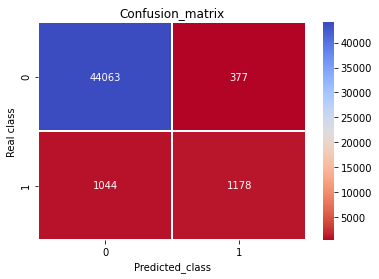


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     44440
           1       0.76      0.53      0.62      2222

    accuracy                           0.97     46662
   macro avg       0.87      0.76      0.80     46662
weighted avg       0.97      0.97      0.97     46662



In [38]:
#Baseline Model
params_model = {'max_iter':700}

lr_model = build_model(LogisticRegression, params_model, X_train_res, y_train_res, X_test_res, y_test_res)

In [39]:
#Function to tabulate the scores
def add_table_metrics(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    f1score = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    all_metrics['f1_score'][model_name] = f1score
    all_metrics['accuracy'][model_name] = acc
    all_metrics['auc'][model_name] = auc

In [40]:
add_table_metrics('LR complete',lr_model, X_test_res, y_test_res)

In [41]:
#Cross validation score
cv_score = cross_val_score(lr_model,X_train_res, y_train_res)
print(f'Avg CV score = {np.mean(cv_score):.3f}') 

Avg CV score = 0.970


In [42]:
#Identify columns with low coefficients to see if scores improves
lr_coef = pd.Series(lr_model.coef_[0], index = X_train_res.columns)
cols2remove = set([name.split('_')[0] for name in list(lr_coef[abs(lr_coef)<1e-7].index)])
cols2remove

{'device', 'geoNetwork', 'trafficSource'}

X shape =  (195153, 88)


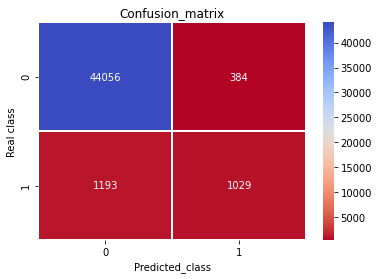


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     44440
           1       0.73      0.46      0.57      2222

    accuracy                           0.97     46662
   macro avg       0.85      0.73      0.77     46662
weighted avg       0.96      0.97      0.96     46662

Avg CV score = 0.966


In [43]:
# drop the features with low coefficients
X_train_filtered = X_train_res[[c for c in X_train_res.columns if c.split('_')[0] not in  cols2remove]]
X_test_filtered = X_test_res[[c for c in X_test_res.columns if c.split('_')[0] not in  cols2remove]]

print('X shape = ',X_train_filtered.shape)


params_model = {'max_iter':600}
lr_model2 = build_model(LogisticRegression, params_model, X_train_filtered, y_train_res, X_test_filtered, y_test_res)


cv_score = cross_val_score(lr_model2,X_train_filtered, y_train_res)
print(f'Avg CV score = {np.mean(cv_score):.3f}')



No Skill: ROC AUC=0.500
Model: ROC AUC=0.976


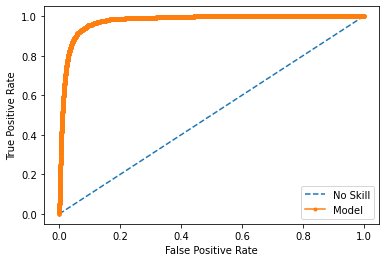

In [44]:
#Plot roc auc curve
plot_roc_curve(lr_model2, X_test_filtered, y_test_res)

In [45]:
#Add scoring to summary
add_table_metrics('LR filtered',lr_model2, X_test_filtered, y_test_res)

In [46]:
params_grid = {'C': np.logspace(-10,10,50)}


lr_grid = GridSearchCV(LogisticRegression(random_state=0, max_iter=700),
                               params_grid, verbose = 1)
lr_grid.fit(X_train_filtered, y_train_res)

best_lr_model = lr_grid.best_estimator_
print('Best Score = ',lr_grid.best_score_)
print('Best params = ', lr_grid.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 22.9min finished


Best Score =  0.9665083279651716
Best params =  {'C': 68.66488450042998}


In [47]:
add_table_metrics('LR GridSearch',best_lr_model, X_test_filtered, y_test_res)

### Extra Trees Classifier

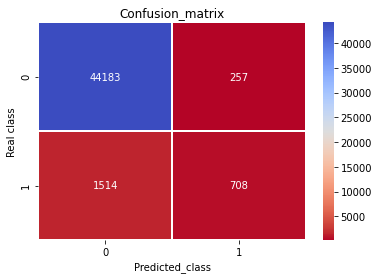


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     44440
           1       0.73      0.32      0.44      2222

    accuracy                           0.96     46662
   macro avg       0.85      0.66      0.71     46662
weighted avg       0.96      0.96      0.95     46662



In [48]:
params_model = {'max_depth':500}
extra_tree = build_model(ExtraTreesClassifier, params_model, X_train_res, y_train_res, X_test_res, y_test_res)


In [49]:
add_table_metrics('ET complete',extra_tree, X_test_res, y_test_res)

In [50]:
#Identify features with low coefficients
feature_importance = pd.Series(extra_tree.feature_importances_, index = X_train_res.columns)
display(feature_importance.sort_values())
cols2remove_tree = set([name.split('_')[0] for name in list(feature_importance[abs(feature_importance)==0].index)])
cols2remove_tree

geoNetwork_region_Valparaiso Region               0.000000
geoNetwork_city_Birkenes                          0.000000
trafficSource_source_amp.reddit.com               0.000000
trafficSource_source_analytics.corp.google.com    0.000000
trafficSource_source_images.google.pt             0.000000
                                                    ...   
totals_bounces_0                                  0.017869
totals_newVisits_0                                0.017988
totals_bounces_1.0                                0.020110
totals_hits                                       0.143630
totals_pageviews                                  0.148090
Length: 1969, dtype: float64

{'device', 'geoNetwork', 'trafficSource'}

X shape =  (195153, 88)


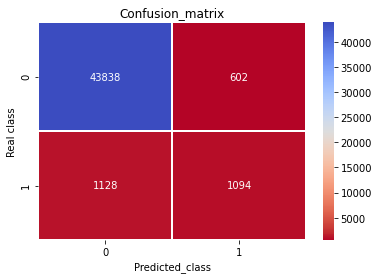


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     44440
           1       0.65      0.49      0.56      2222

    accuracy                           0.96     46662
   macro avg       0.81      0.74      0.77     46662
weighted avg       0.96      0.96      0.96     46662

Avg CV score = 0.963


In [51]:
# drop the features with low coefficients
X_train_filtered = X_train_res[[c for c in X_train_res.columns if c.split('_')[0] not in  cols2remove]]
X_test_filtered = X_test_res[[c for c in X_test_res.columns if c.split('_')[0] not in  cols2remove]]

print('X shape = ',X_train_filtered.shape)

params_model = {'max_depth':100}
extra_tree2 = build_model(ExtraTreesClassifier, params_model, X_train_filtered, y_train_res, X_test_filtered, y_test_res)

cv_score = cross_val_score(extra_tree2,X_train_filtered, y_train_res)
print(f'Avg CV score = {np.mean(cv_score):.3f}')

No Skill: ROC AUC=0.500
Model: ROC AUC=0.973


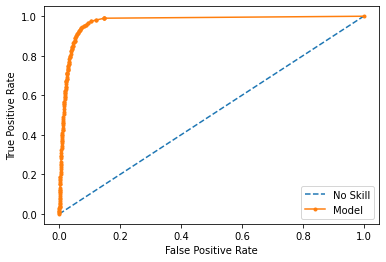

In [52]:
plot_roc_curve(extra_tree2, X_test_filtered, y_test_res)

In [53]:
#Add scoring to summary results
add_table_metrics('ET filtered',extra_tree2, X_test_filtered, y_test_res)

In [54]:
#Use Grid Search to find best params
params_grid = {'n_estimators': np.arange(50,600,80),
               'max_depth': [3,4,5],
               'max_leaf_nodes': [5,7,9]}

extra_tree = ExtraTreesClassifier(random_state=0)

extra_tree_grid = GridSearchCV(extra_tree, params_grid, verbose = 1)
extra_tree_grid.fit(X_train_filtered, y_train_res)

best_extra_tree = extra_tree_grid.best_estimator_
print('Best Score = ',extra_tree_grid.best_score_)
print('Best params = ', extra_tree_grid.best_params_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed: 77.0min finished


Best Score =  0.9523809525309946
Best params =  {'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 50}


In [55]:
add_table_metrics('ET GridSearch', best_extra_tree, X_test_filtered, y_test_res)

### Gradient Boosting

X shape =  (195153, 88)


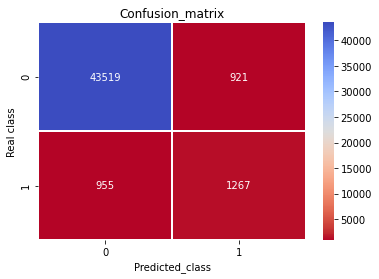


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     44440
           1       0.58      0.57      0.57      2222

    accuracy                           0.96     46662
   macro avg       0.78      0.77      0.78     46662
weighted avg       0.96      0.96      0.96     46662

Avg CV score = 0.960


In [56]:
# Use grid search to find best parameters on the same features selected by Logistic Regression (better accuracy then extra tree)

X_train_filtered = X_train_res[[c for c in X_train_res.columns if c.split('_')[0] not in  cols2remove]]
X_test_filtered = X_test_res[[c for c in X_test_res.columns if c.split('_')[0] not in  cols2remove]]

print('X shape = ',X_train_filtered.shape)

params_model = {'max_depth':100}
gb_tree = build_model(GradientBoostingClassifier, params_model, X_train_filtered, y_train_res, X_test_filtered, y_test_res)

cv_score = cross_val_score(gb_tree,X_train_filtered, y_train_res)
print(f'Avg CV score = {np.mean(cv_score):.3f}')


In [57]:
params_grid = {'learning_rate': np.arange(0.05,0.2,0.05),
               'n_estimators': np.arange(10,50,10),
               'max_depth': [1,2,3],
               'max_leaf_nodes': [3,5,7]}

gb_tree2 = GradientBoostingClassifier(random_state=0)

clf = GridSearchCV(gb_tree2, params_grid, verbose = 1)
clf.fit(X_train_filtered, y_train_res)

best_tree = clf.best_estimator_
print('Best Score = ',clf.best_score_)
print('Best params = ', clf.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed: 77.0min finished


Best Score =  0.9674255591643511
Best params =  {'learning_rate': 0.2, 'max_depth': 3, 'max_leaf_nodes': 5, 'n_estimators': 40}


No Skill: ROC AUC=0.500
Model: ROC AUC=0.982


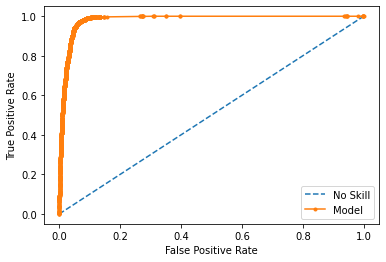

In [58]:
plot_roc_curve(clf, X_test_filtered, y_test_res)

In [59]:
add_table_metrics('GB GridSearch', best_tree, X_test_filtered, y_test_res)

In [64]:
#Compute the recall score for the best performing model 
print('Train Recall Score: ', round(recall_score(y_train_res, clf.predict(X_train_filtered)), 3))
print('Test Recall Score: ', round(recall_score(y_test_res, clf.predict(X_test_filtered)), 3))

Train Recall Score:  0.617
Test Recall Score:  0.604


## Summary Results

In [60]:
pd.DataFrame(all_metrics)

,f1_score,accuracy,auc
LR complete,0.623775,0.969547,0.760835
LR filtered,0.566162,0.966204,0.727228
LR GridSearch,0.567107,0.966268,0.727689
ET complete,0.444305,0.962046,0.656424
ET filtered,0.558448,0.962925,0.739401
ET GridSearch,0.000000,0.952381,0.500000
GB GridSearch,0.634515,0.966868,0.794487


## Conclusion and Further Considerations

Logistic Regression, Extra Trees and Gradient Boosting models are used to model the data. There is a heavy class-imbalance in the data, at 100:1 ratio of non-revenue generating against revenue generating sessions. Random UnderSampler was used to adjust for the imbalance using the sampling strategy of 1:20. 

Gradient Boosting has shown to be the best performing model at an overall accuracy of 96.7%,with f1 score and auc scores of 63% and 79% respectively. ROC-AUC score achieved 98% using this method.

While this may seem pretty good results, the test recall score works out to be 60% which is expectedly lower due to the highly imabalanced data and by using random undersampling: All of the training data points from the minority class (revenue generating) are used but instances are randomly removed from the majority training set till the desired balance is achieved which in this case the ratio applied was 1:20. One disadvantage of this approach is that some useful information might be lost from the majority class due to the undersampling.

One future consideration is to use undersampling methods in conjunction with an oversampling technique for the minority class, which may results in better performance than using oversampling or undersampling alone on the training dataset and for the next iteration, the classifier model should be applied on unseen data to validate the scoring